# Features de TextMining:

---------------------------------

### Importando dependências

In [1]:
import os
import sys
import re
import datetime
import dateutil

sys.path.insert(0,os.path.dirname(os.getcwd()))
sys.path.insert(0,os.path.join(os.getcwd(),'grobid'))
sys.path.insert(0,os.getcwd())

import numpy as np
import pandas as pd

from grobid import grobid_client
import grobid_tei_xml
from grobid_to_dataframe import grobid_cli, xmltei_to_dataframe

import plotly

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from pyvis.network import Network

!pip install nltk --upgrade

!pip install gensim --upgrade

!pip install spacy --upgrade

!pip install stanford-corenlp --upgrade

!pip install corenlp --upgrade

!pip install textblob --upgrade

!pip install transformers --upgrade

!pip install pyvis

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---------------------------------

### Comandos Docker

docker run -t --rm --init -p 8080:8070 -p 8081:8071 --memory="9g" lfoppiano/grobid:0.7.0

docker run -t --rm --init -p 8080:8070 -p 8081:8071 lfoppiano/grobid:0.6.2

pip install grobid-tei-xml

### Definindo variáveis e caminhos

In [3]:
path = os.path.dirname(os.getcwd())
path_input = os.path.join(path,'artifacts','articles','ml_material','teste')

---------------------------------

### Funções para execução em batch

In [4]:
def get_path(path_input_path):
    """"""
    if os.path.exists(path_input_path):
        return path_input_path
    
    return os.getcwd()


def batch_process_path(path_input_path, n_workers=2,
                       check_cache=True,
                       cache_folder_name='summarticles_cache',
                       config_path="./grobid/config.json"):
    
    """"""
    
    gcli = grobid_cli(config_path=config_path)
    result_batch = gcli.process_pdfs(input_path=path_input_path,
                                     check_cache=check_cache,
                                     cache_folder_name=cache_folder_name,
                                     n_workers=n_workers,
                                     service="processFulltextDocument",
                                     generateIDs=True,
                                     include_raw_citations=True,
                                     include_raw_affiliations=True,
                                     consolidate_header=False,
                                     consolidate_citations=False,
                                     tei_coordinates=False,
                                     segment_sentences=True,
                                     verbose=True)
    return result_batch


def get_dataframes(result_batch):
    
    """"""
    
    xml_to_df = xmltei_to_dataframe()
    dict_dfs, dic_errors = xml_to_df.get_dataframe_articles(result_batch)
    
    return dict_dfs, dic_errors


def files_path(path):
    list_dir = os.listdir(path)
    files = []
    for file in list_dir:
        if os.path.isfile(os.path.join(path,file)):
            files.append(os.path.join(path,file))
    return files

In [5]:
def run_batch_process(path_input, n_workers=6, check_cache=True, 
                      cache_folder_name='summarticles_cache', 
                      config_path="./grobid/config.json"):

    dict_exec = {'path':path_input}
    dict_exec['start_datetime'] = datetime.datetime.now()
    
    # path_input = os.path.join(path,'artifacts','test_article')
    config_path = os.path.join(os.getcwd(),'grobid','config.json')
    dict_exec['grobid_config'] = config_path
    
    gcli = grobid_client.GrobidClient(config_path=config_path, check_server=False)
    
    dict_exec['files'] = gcli.get_input_files(path_input)
    dict_exec['num_files'] = len(dict_exec['files'])
    dict_exec['n_workers'] = n_workers
    
    path_input_path = get_path(path_input)
    result_batch = batch_process_path(path_input_path, n_workers=dict_exec['n_workers'], check_cache=check_cache)
    dict_dfs, dic_errors = get_dataframes(result_batch)
    
    gcli.save_xmltei_files(result_batch, input_folder_path, cache_folder_name=cache_folder_name)
    
    dict_exec['end_datetime'] = datetime.datetime.now()
    dict_exec['time_exec_sec'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    dict_exec['time_exec_min'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    
    return dict_dfs, dict_exec, dic_errors

In [6]:
input_folder_path = r"""C:\Users\vierb\OneDrive\Área de Trabalho\Projetos\PGC\artifacts\articles\ml_material"""

In [7]:
%%time
dict_dfs, dict_exec, dic_errors = run_batch_process(path_input=input_folder_path, 
                                                    n_workers=10, 
                                                    check_cache=True, 
                                                    cache_folder_name='summarticles_cache', 
                                                    config_path="./grobid/config.json")

GROBID server is up and running
587 files to process in current batch
[Input Files] 587
[Cache Files] 587
In the end, we have: 0  new files to process!
And we have : 587  files to back from cache!
Processed articles: 581
Number articles with errors: 6
Wall time: 26.8 s


In [8]:
print(dict_exec.keys())

dict_keys(['path', 'start_datetime', 'grobid_config', 'files', 'num_files', 'n_workers', 'end_datetime', 'time_exec_sec', 'time_exec_min'])


In [9]:
dic_errors

{'number_article_error': 6,
 'list_article_error': [{'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.110166.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index',
   'keys_dict': dict_keys(['grobid_version', 'grobid_timestamp', 'header', 'pdf_md5', 'language_code', 'citations', 'abstract'])},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.109782.pdf',
   'error': xml.etree.ElementTree.ParseError,
   'error_text': 'syntax error: line 1, column 0',
   'keys_dict': dict_keys(['grobid_version', 'grobid_timestamp', 'header', 'pdf_md5', 'language_code', 'citations', 'abstract', 'body', 'annex'])},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\s41578-021-00351-7.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you

In [10]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:08:00,2022-05-15 02:11:00,2022-05-15 02:08:00
language_code,en,en,en
acknowledgement,Acknowledgement Financial and logistic support...,Acknowledgments,NaN
abstract,Failure behavior of Zn coated Fe is simulated ...,Artificial intelligence (AI) based approaches ...,Mahalanobis Distance (MD) and grey relational ...
body,Introduction Zinc forms a protective coating o...,Introduction Over the course of less than a ce...,Introduction Cracks in concrete structures are...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [11]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,2009-05-15,2020-12-26,2012-08-04
title_head,Analyzing Fe-Zn system using molecular dynamic...,Polymer informatics: Current status and critic...,An evaluation of Mahalanobis Distance and grey...
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [12]:
dict_dfs['df_doc_authors'].head(3).T

pdf_md5,8322E288CEF9C48A429B4A6262DC664B,8322E288CEF9C48A429B4A6262DC664B,8322E288CEF9C48A429B4A6262DC664B
full_name_author,Baidurya Bhattacharya,G R Dinesh Kumar,Akash Agarwal
given_name_author,Baidurya,G,Akash
middle_name_author,NaN,R,NaN
surname_author,Bhattacharya,Dinesh Kumar,Agarwal
email_author,NaN,NaN,NaN
orcid_author,NaN,NaN,NaN
institution_author,Indian Institute of Technology,Indian Institute of Technology,Indian Institute of Technology
department_author,Department of Civil Engineering,Department of Metallurgical and Materials Engi...,Department of Metallurgical and Materials Engi...
laboratory_author,NaN,NaN,NaN
addr_line_author,NaN,NaN,NaN


In [13]:
dict_dfs['df_doc_citations'].head(5)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
8322E288CEF9C48A429B4A6262DC664B,0,b0,"P. Bicao, W. Jianhua, S. Xuping, L. Zhi, Y. Fu...",2008,NaN,NaN,NaN,Surf. Coat. Technol,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,1,b1,"H. Asgari, M.R. Toroghinejad, M.A. Golozar, Cu...",2009,NaN,NaN,NaN,Curr. Appl. Phys,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,2,b2,"E.M. Bellhouse, J.R. McDermid, Mater. Sci. Eng...",2008,NaN,NaN,NaN,Mater. Sci. Eng. A -Struct,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,3,b3,"G. Reumont, P. Perrot, J.M. Fiorani, J. Hertz,...",2000,NaN,NaN,NaN,J. Phase Equilib,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,4,b4,"N. Chakraborti, Int. Mater. Rev. 49 (2004) 246.",2004,NaN,NaN,NaN,Int. Mater. Rev,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
dict_dfs['df_doc_authors_citations'].head(5)

,id,index,full_name_citation,given_name_citation,middle_name_citation,surname_citation,email_citation,orcid_citation,institution_citation,department_citation,laboratory_citation,addr_line_citation,post_code_citation,settlement_citation,country_citation
pdf_md5,,,,,,,,,,,,,,,
8322E288CEF9C48A429B4A6262DC664B,b0,0,P Bicao,P,NaN,Bicao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,b0,0,W Jianhua,W,NaN,Jianhua,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,b0,0,S Xuping,S,NaN,Xuping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,b0,0,L Zhi,L,NaN,Zhi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8322E288CEF9C48A429B4A6262DC664B,b0,0,Y Fucheng,Y,NaN,Fucheng,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------

### Trabalhando no tratamento do texto

!pip install pytorch --upgrade

!pip install tensorflow --upgrade --user

In [15]:
import nltk
import spacy
import corenlp
import textblob
import gensim
#import transformers

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

--------------------------------

Estudando a distribuição de caracteres especiais:

In [17]:
list_chars = []
for id,row in dict_dfs['df_doc_info'].iterrows():
    for c in row['raw_data']:
        list_chars.append(c)
        
df_counts = pd.DataFrame({'chars':pd.value_counts(list_chars).index.tolist(),'counts':pd.value_counts(list_chars).tolist()})
df_counts = df_counts.sort_values(by='counts',ascending=False)

import plotly.express as px
fig = px.bar(df_counts.head(20), x='chars', y='counts')
fig.show()

In [18]:
df_counts.sort_values(by='counts',ascending=False).tail(30)

,chars,counts
741,𝟕,1
740,𝑰,1
739,𝐨,1
742,и,1
749,┬,1
760,⇑,1
726,Ⅵ,1
750,⑥,1
752,ቀ,1
753,ቁ,1


--------------------------------

Tratando texto:

In [20]:
def text_tokenize(text, language='english', preserve_line=False):
    return nltk.tokenize.word_tokenize(text, language=language, preserve_line=preserve_line)

def clean_text_regex(words_list, regex="[^a-zA-Z]+", replace='', min_word_len=1):
    """Testado em https://regex101.com/"""
    new_words = []
    for word in words_list:
        word = re.sub(regex, replace, word)
        if len(word) > min_word_len:
            new_words.append(word)
    return new_words

def remove_stopwords(words_list, stopwords_list):
    """"""
    new_words = []
    for word in words_list:
        if word not in stopwords_list:
            new_words.append(word)
    return new_words

def lemmatizer(words_list):
    """"""
    obj_lemmatizer = nltk.stem.WordNetLemmatizer()
    words_lemma = []
    for word in words_list:
        words_lemma.append(obj_lemmatizer.lemmatize(word,pos=nltk.corpus.wordnet.VERB))
    return words_lemma

def stem_text(words_list):
    """"""
    p_stem = nltk.stem.PorterStemmer()
    words_stem = []
    for word in words_list:
        words_stem.append(p_stem.stem(word))
    return words_stem

In [21]:
def text_prep(text, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, text_lower=False, stopwords_list=[], language='english',
              preserve_line=False, regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1):
    
    """Text preparation."""
    
    text_preparation = text_tokenize(text, language=language, preserve_line=preserve_line)
    if clean_text:
        text_preparation = clean_text_regex(words_list=text_preparation,
                                            regex=regex_chars_clean,
                                            replace=replace_chars_clean,
                                            min_word_len=min_word_len)
    if stopwords_remove:
        text_preparation = remove_stopwords(words_list=text_preparation,
                                            stopwords_list=stopwords_list)
    if exec_lemmatizer:
        text_preparation = lemmatizer(words_list=text_preparation)
    if exec_stem:
        text_preparation = stem_text(words_list=text_preparation)
    text_preparation = ' '.join(text_preparation)
    if text_lower:
        text_preparation = text_preparation.lower()
    return text_preparation

In [22]:
def text_prep_column(colum_df):
    """"""
    f_prep_text = lambda text_data: text_prep(text=text_data, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, 
                                            stopwords_list=nltk.corpus.stopwords.words('english'), language='english', preserve_line=False,
                                            regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1, text_lower=True)
    colum_df = colum_df.apply(lambda e: e if pd.isna(e) else f_prep_text(e))
    return colum_df

In [23]:
dict_dfs['df_doc_info'].abstract.iat[0]

'Failure behavior of Zn coated Fe is simulated through molecular dynamics (MD) and the energy absorbed at the onset of failure along with the corresponding strain of the Zn lattice are computed for different levels of applied shear rate, temperature and thickness. Data-driven models are constructed by feeding the MD results to an evolutionary neural network. The outputs of these neural networks are utilized to carry out a multi-objective optimization through genetic algorithms, where the best possible tradeoffs between two conflicting requirements, minimum deformation and maximum energy absorption at the onset of failure, are determined by constructing a Pareto frontier.'

In [24]:
text_prep(text=dict_dfs['df_doc_info'].abstract.iat[0],
          clean_text=True,
          stopwords_remove=True,
          exec_lemmatizer=True,
          exec_stem=False,
          text_lower=True,
          stopwords_list=nltk.corpus.stopwords.words('english'),
          language='english',
          preserve_line=False,
          regex_chars_clean="[^a-zA-Z]+",
          replace_chars_clean='',
          min_word_len=1)

'failure behavior zn coat fe simulate molecular dynamics md energy absorb onset failure along correspond strain zn lattice compute different level apply shear rate temperature thickness datadriven model construct feed md result evolutionary neural network the output neural network utilize carry multiobjective optimization genetic algorithms best possible tradeoffs two conflict requirements minimum deformation maximum energy absorption onset failure determine construct pareto frontier'

In [25]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:08:00,2022-05-15 02:11:00,2022-05-15 02:08:00
language_code,en,en,en
acknowledgement,Acknowledgement Financial and logistic support...,Acknowledgments,NaN
abstract,Failure behavior of Zn coated Fe is simulated ...,Artificial intelligence (AI) based approaches ...,Mahalanobis Distance (MD) and grey relational ...
body,Introduction Zinc forms a protective coating o...,Introduction Over the course of less than a ce...,Introduction Cracks in concrete structures are...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [26]:
dict_dfs['df_doc_info']['acknowledgement_prep'] = text_prep_column(dict_dfs['df_doc_info']['acknowledgement'])
dict_dfs['df_doc_info']['abstract_prep'] = text_prep_column(dict_dfs['df_doc_info']['abstract'])
dict_dfs['df_doc_info']['body_prep'] = text_prep_column(dict_dfs['df_doc_info']['body'])

In [27]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:08:00,2022-05-15 02:11:00,2022-05-15 02:08:00
language_code,en,en,en
acknowledgement,Acknowledgement Financial and logistic support...,Acknowledgments,NaN
abstract,Failure behavior of Zn coated Fe is simulated ...,Artificial intelligence (AI) based approaches ...,Mahalanobis Distance (MD) and grey relational ...
body,Introduction Zinc forms a protective coating o...,Introduction Over the course of less than a ce...,Introduction Cracks in concrete structures are...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------------

Word Cloud:

!pip install wordcloud

In [28]:
from wordcloud import WordCloud
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sb

In [29]:
def word_cloud(documents, width=1000, height=200, collocations=True, background_color='white'):
    """Create and plot a wordcloud from documents list."""
    objWC = WordCloud(collocations=collocations, background_color=background_color, width=width, height=height)
    text = ' '.join([ ' ' if pd.isna(t) else t for t in documents])
    objWC = objWC.generate_from_text(text)
    ax = plt.imshow(objWC)
    plt.axis("off")
    plt.show()

In [30]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

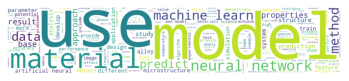

In [31]:
word_cloud(documents, width=1000, height=200, collocations=True, background_color='white')

--------------------------------

Criando BOW e TFIDF:

In [32]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

In [33]:
obj_bow = CountVectorizer(encoding="utf-8",
                          stop_words="english",
                          strip_accents="ascii",
                          lowercase=True, 
                          preprocessor=None,
                          tokenizer=None,
                          token_pattern=r"""(?u)\b\w\w+\b""",
                          ngram_range=(1,2), # Unigram and bigram
                          analyzer="word",
                          max_df=1.0,
                          min_df=2, # May have at least 2 frequency
                          max_features=None, 
                          vocabulary= None, 
                          binary=False, 
                          dtype=np.int64)

obj_tfidf = TfidfVectorizer(encoding="utf-8",
                            stop_words="english",
                            strip_accents="ascii",
                            lowercase=True, 
                            preprocessor=None,
                            tokenizer=None,
                            token_pattern=r"""(?u)\b\w\w+\b""",
                            ngram_range=(1,2), # Unigram and bigram
                            analyzer="word",
                            max_df=1.0,
                            min_df=2, # May have at least 2 frequency
                            max_features=None, 
                            vocabulary= None, 
                            binary=False, 
                            dtype=np.float64, 
                            norm='l2', 
                            use_idf=True, 
                            smooth_idf=True, 
                            sublinear_tf=False)

obj_bow = obj_bow.fit(raw_documents=documents)
bow_matrix = obj_bow.transform(documents)

obj_tfidf = obj_tfidf.fit(raw_documents=documents)
tfidf_matrix = obj_tfidf.transform(documents)

bow_matrix = bow_matrix.todense()
tfidf_matrix = tfidf_matrix.todense()

df_bow = pd.DataFrame(bow_matrix, columns=obj_bow.get_feature_names())
df_tfidf = pd.DataFrame(tfidf_matrix, columns=obj_tfidf.get_feature_names())

In [34]:
df_bow.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_tfidf.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.235093,0.0,0.139353,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------

Trabalhando com a similaridade de Cosseno:

In [36]:
cos_bow_sim = cosine_similarity(df_bow, df_bow)
cos_tfidf_sim = cosine_similarity(df_tfidf, df_tfidf)

df_cos_bow_sim = pd.DataFrame(cos_bow_sim,
                              columns=dict_dfs['df_doc_info'].index.tolist(),
                              index=dict_dfs['df_doc_info'].index.tolist())

df_cos_tfidf_sim = pd.DataFrame(cos_tfidf_sim,
                                columns=dict_dfs['df_doc_info'].index.tolist(),
                                index=dict_dfs['df_doc_info'].index.tolist())

In [37]:
df_cos_bow_sim.head()

,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7,F94F1316837B82B63E34665811E88EAC,1AB761F2FDBBF54C420703FDB7EDA202,C1B5CAAD4EAA907B625B74BB9EB976AE,428864F6796D33B978DE493DDA7D9294,488128866533362EA8D46AACFB7E97BB,6B99A2264DE9087FCB01DDEB5441EDB9,F2322BD5F502A6BDCEA8A377F3BD7564,...,CF080E621D4E5B7F1002AD78612044EA,24197BD23DA595ACFAF7F87223BCE0D0,AD0485C8E47105AAFAD9C18F62DDAF65,0E86E2E2BCF42A255E31152552C7A4AD,8A754E3CEA622AE2A3183A05CE50CAF9,10AA013F28F1E33724DF0A74A3914012,BE13757732B3FB8F16C9F5AB1B4FD3F1,3A373DAD8B44C8121C47D63E51D32B9F,B377BA784F09287B66081E0FABE237CB,F00A22A3228F8F2B862733A7CF932CE7
8322E288CEF9C48A429B4A6262DC664B,1.000000,0.036703,0.144338,0.089644,0.085049,0.068599,0.112946,0.104210,0.020371,0.026172,...,0.049411,0.053351,0.160855,0.148731,0.013933,0.201184,0.116970,0.149515,0.039950,0.240201
52D1C947BEF055004152865F5AF5AE6C,0.036703,1.000000,0.127143,0.072713,0.053066,0.057070,0.105709,0.140881,0.095329,0.093899,...,0.088636,0.116509,0.087820,0.066816,0.082590,0.058580,0.086885,0.101402,0.156682,0.074937
974E573D8EB6EAFAE4DCF4D83FBA8FA7,0.144338,0.127143,1.000000,0.100924,0.053567,0.108916,0.146722,0.142893,0.057336,0.033999,...,0.096280,0.123208,0.156717,0.051522,0.048266,0.121961,0.091652,0.090075,0.133448,0.110511
F94F1316837B82B63E34665811E88EAC,0.089644,0.072713,0.100924,1.000000,0.565572,0.135904,0.286873,0.079405,0.041910,0.101707,...,0.062122,0.138216,0.128695,0.168633,0.050961,0.202351,0.346326,0.196151,0.156552,0.171587
1AB761F2FDBBF54C420703FDB7EDA202,0.085049,0.053066,0.053567,0.565572,1.000000,0.126234,0.267222,0.082184,0.056229,0.108363,...,0.068193,0.084149,0.134785,0.126678,0.082413,0.275013,0.325062,0.143546,0.076515,0.236790


In [38]:
df_cos_tfidf_sim.head()

,8322E288CEF9C48A429B4A6262DC664B,52D1C947BEF055004152865F5AF5AE6C,974E573D8EB6EAFAE4DCF4D83FBA8FA7,F94F1316837B82B63E34665811E88EAC,1AB761F2FDBBF54C420703FDB7EDA202,C1B5CAAD4EAA907B625B74BB9EB976AE,428864F6796D33B978DE493DDA7D9294,488128866533362EA8D46AACFB7E97BB,6B99A2264DE9087FCB01DDEB5441EDB9,F2322BD5F502A6BDCEA8A377F3BD7564,...,CF080E621D4E5B7F1002AD78612044EA,24197BD23DA595ACFAF7F87223BCE0D0,AD0485C8E47105AAFAD9C18F62DDAF65,0E86E2E2BCF42A255E31152552C7A4AD,8A754E3CEA622AE2A3183A05CE50CAF9,10AA013F28F1E33724DF0A74A3914012,BE13757732B3FB8F16C9F5AB1B4FD3F1,3A373DAD8B44C8121C47D63E51D32B9F,B377BA784F09287B66081E0FABE237CB,F00A22A3228F8F2B862733A7CF932CE7
8322E288CEF9C48A429B4A6262DC664B,1.000000,0.017313,0.104576,0.018793,0.017422,0.012424,0.019339,0.018321,0.015174,0.003081,...,0.012255,0.026569,0.033601,0.035206,0.009638,0.055990,0.034403,0.055921,0.015343,0.086996
52D1C947BEF055004152865F5AF5AE6C,0.017313,1.000000,0.034520,0.015101,0.013381,0.014317,0.022844,0.048939,0.042036,0.042283,...,0.037591,0.025131,0.050417,0.024450,0.027043,0.016039,0.022401,0.020965,0.053813,0.022374
974E573D8EB6EAFAE4DCF4D83FBA8FA7,0.104576,0.034520,1.000000,0.022532,0.025228,0.028289,0.037234,0.033490,0.012997,0.014929,...,0.048615,0.020080,0.048873,0.014176,0.021503,0.041640,0.019293,0.018815,0.033485,0.028995
F94F1316837B82B63E34665811E88EAC,0.018793,0.015101,0.022532,1.000000,0.552264,0.052352,0.129585,0.019117,0.010061,0.023056,...,0.012659,0.024285,0.037991,0.028745,0.014338,0.057110,0.165359,0.023575,0.032733,0.036503
1AB761F2FDBBF54C420703FDB7EDA202,0.017422,0.013381,0.025228,0.552264,1.000000,0.039972,0.118026,0.018746,0.018503,0.025293,...,0.016251,0.025734,0.029068,0.020921,0.028145,0.119461,0.164614,0.024630,0.021732,0.069431


Gerando grafo de similaridade de cosseno:

In [39]:
def filter_sim_matrix(matrix, percentil="75%", value_min=0, value_max=1):
    """"""
    list_elements = []
    for colum in df_cos_tfidf_sim.columns.tolist():
        list_elements += df_cos_tfidf_sim[colum].tolist()
    sim_describe = pd.Series(list_elements).describe(percentiles=np.arange(0, 1, 0.001))
    del list_elements
    
    filter_matrix = sim_describe[percentil]
    
    list_filter = []
    for i,row in matrix.iterrows():
        for j in row.index:
            value = matrix.loc[i,j]
            logic_filter = value>=filter_matrix and value>value_min and value<value_max
            if not pd.isna(value) and logic_filter:
                dictCell = {"doc_a":i,"doc_b":j,'value':matrix.loc[i,j]}
                list_filter.append(dictCell)
    df_maxtrix_filter = pd.DataFrame(list_filter)
    del list_filter
    
    return df_maxtrix_filter

In [41]:
def make_sim_graph(matrix,
                   node_data,
                   source_column="doc_a",
                   to_column="doc_b",
                   value_column="value",
                   height="500px",
                   width="500px",
                   directed=False,
                   notebook=False,
                   bgcolor="#ffffff",
                   font_color=False,
                   layout=None,
                   heading="",
                   path_graph="./", 
                   name_file="graph.html"):
    """"""
    graph = Network(height=height,
                    width=width,
                    directed=directed,
                    notebook=notebook,
                    bgcolor=bgcolor,
                    font_color=font_color,
                    layout=layout,
                    heading=heading)

    for i, row in node_data.iterrows():
        
        article_id = str(row['pdf_md5'])
        article_title = str(row['title_head'])
        article_abstract_short = str(row['abstract_short'])
        article_date = str(row['date_head'])
        article_number_authors = str(row['author_count'])
        article_number_citations = str(row['citation_count'])
        article_doi = str(row['doi_head'])
        article_file_name = str(row['file_name'])
        article_file_path = str(row['file'])
        
        title_html = f"""Article Title:{article_title}
                         Article Date:{article_date}
                         Article Number Authors:{article_number_authors}
                         Article Number Citations:{article_number_citations}
                         Article DOI:{article_doi}
                         Article File Name:{article_file_name}"""
        
        graph.add_node(n_id=article_id, 
                       label=f"Node ID: {str(article_id)[0:4]}", 
                       borderWidth=1, 
                       borderWidthSelected=2, 
                       #brokenImage="url", 
                       #group="a", 
                       #hidden=False, 
                       #image="url", 
                       #labelHighlightBold=True, 
                       #level=1, 
                       #mass=1, 
                       #physics=True,
                       shape="dot", # image, circularImage, diamond, dot, star, triangle, triangleDown, square and icon
                       size=1, 
                       title=title_html,  
                       #x=0.5, 
                       #y=1.0)
                       value=1)
        
    for i,row in matrix.iterrows():
        
        graph.add_edge(source=row[source_column],
                       to=row[to_column],
                       value=round(row[value_column],1),
                       title=row[value_column])
                       #width=row['value'],
                       #arrowStrikethrough=False,
                       #physics=False,
                       #hidden=False)
    
    graph.force_atlas_2based(gravity=-50,
                             central_gravity=0.01,
                             spring_length=360,
                             spring_strength=0.08,
                             damping=0.4,
                             overlap=0)
    
    graph.save_graph(os.path.join(path_graph, name_file))
    graph.show_buttons(filter_=['physics'])
    graph.show(name_file)
    return graph   

In [42]:
df_cos_bow_sim_filter = filter_sim_matrix(df_cos_bow_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_bow_sim_filter = df_cos_bow_sim_filter.nlargest(300,'value')

df_cos_tfidf_sim_filter = filter_sim_matrix(df_cos_tfidf_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_tfidf_sim_filter = df_cos_tfidf_sim_filter.nlargest(300,'value')

In [43]:
# Selecting head article data
cols_head = ['title_head', 'doi_head', 'date_head',]
head_data = dict_dfs['df_doc_head'].loc[:,cols_head].reset_index().copy()
head_data['title_head'] = head_data['title_head'].apply(lambda e: str(e)[0:50] + "..." if len(str(e)) > 50 else str(e))

# Selecting head article data
cols_info = ['abstract','file']
doc_info_data = dict_dfs['df_doc_info'].loc[:,cols_info].reset_index().copy()
doc_info_data['file_name'] = doc_info_data['file'].apply(lambda e: os.path.split(e)[-1])
doc_info_data['abstract_short'] = doc_info_data['abstract'].apply(lambda e: str(e)[0:20] + "..." if len(str(e)) > 20 else str(e))
doc_info_data.drop(labels=['abstract'], axis=1, inplace=True)

# Selecting authors information
authors_data = dict_dfs['df_doc_authors'].reset_index()
authors_data = authors_data.groupby(by=['pdf_md5'], as_index=False)['full_name_author'].count()
authors_data.rename(columns={'full_name_author':'author_count'}, inplace=True)

# Selecting citations information
citations_data = dict_dfs['df_doc_citations'].reset_index()
citations_data = citations_data.groupby(by=['pdf_md5'], as_index=False)['index_citation'].count()
citations_data.rename(columns={'index_citation':'citation_count'}, inplace=True)

nodes = list(set(df_cos_bow_sim_filter.doc_a.tolist()+df_cos_bow_sim_filter.doc_b.tolist()))
df_nodes = pd.DataFrame(nodes, columns=['pdf_md5'])

df_nodes = df_nodes.merge(head_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(doc_info_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(authors_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(citations_data, how='left', on='pdf_md5')

In [44]:
sim_graph = make_sim_graph(matrix=df_cos_bow_sim_filter,
                           node_data=df_nodes,
                           source_column="doc_a",
                           to_column="doc_b",
                           value_column="value",
                           height="1000px",
                           width="1000px",
                           directed=True,
                           notebook=False,
                           bgcolor="#ffffff",
                           font_color=False,
                           layout=None,
                           heading="",
                           path_graph="./", 
                           name_file="graph.html")

In [ ]:
dict_dfs.keys()

dict_keys(['df_doc_info', 'df_doc_head', 'df_doc_authors', 'df_doc_citations', 'df_doc_authors_citations'])

In [ ]:
df_nodes.head(3).T

,0,1,2
pdf_md5,22469F3F29436D0DA57F8E626941F627,9BEBA8ECF7E7037BAAFB6E4CEAD0DC43,1F79E1760A42B6D9E6F31886E30D5086
title_head,Predicting lattice constant of complex cubic p...,Journal Pre-proof Optimizing convolutional neu...,Journal Pre-proof Alloy design and properties ...
doi_head,10.1016/j.commatsci.2011.01.035,10.1016/j.matchar.2020.110119,10.1016/j.msea.2020.140576
date_head,2011-02-17,2020-01-02,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
file_name,j.commatsci.2011.01.035.pdf,j.matchar.2020.110119.pdf,j.msea.2020.140576.pdf
abstract_short,"Recently in the field of materials science, ad...",This is a PDF file of an article that has unde...,Alloy design and properties optimization of mu...
author_count,3,4,6
citation_count,47,37,58


In [ ]:
dict_dfs['df_doc_citations'].head(3)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
523B371494B6095FE98EDAF9EE8E0B59,0,b0,"Geoffroy Hautier, Christopher C. Fischer, Anub...",2010,Finding nature's missing ternary oxide compoun...,NaN,NaN,Chemistry of Materials,NaN,NaN,...,3762,3767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523B371494B6095FE98EDAF9EE8E0B59,1,b1,"B. Meredig, A. Agrawal, S. Kirklin, J. E. Saal...",2014,Combinatorial screening for new materials in u...,NaN,NaN,Phys. Rev. B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523B371494B6095FE98EDAF9EE8E0B59,2,b2,"Paul Raccuglia, Katherine C. Elbert, Philip D....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_cos_bow_sim_filter.head(3).T

,0,1,2
doc_a,523B371494B6095FE98EDAF9EE8E0B59,E5A28CF0AED9C0EBDB2275FCB942A3AA,551F431A61C25CFF815884ADAF6C3D66
doc_b,4422168E77088AC4525D4737978C57DF,4422168E77088AC4525D4737978C57DF,4422168E77088AC4525D4737978C57DF
value,0.196846,0.253625,0.269227
title_head_e,Machine learning materials physics: Surrogate ...,Active learning of linearly parametrized inter...,Computational Materials Science
doi_head_e,10.1016/j.cma.2018.10.025,10.1016/j.commatsci.2017.08.031,10.1016/j.commatsci.2019.03.054
date_head_e,2018-10-17,NaN,NaN
pdf_md5,4422168E77088AC4525D4737978C57DF,4422168E77088AC4525D4737978C57DF,4422168E77088AC4525D4737978C57DF
title_head_b,Computational Materials Science,Computational Materials Science,Computational Materials Science
doi_head_b,10.1016/j.commatsci.2018.08.041,10.1016/j.commatsci.2018.08.041,10.1016/j.commatsci.2018.08.041
date_head_b,NaN,NaN,NaN


In [ ]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,523B371494B6095FE98EDAF9EE8E0B59,1451EBDA3D877A66CD0810390DA1F79A,E5A28CF0AED9C0EBDB2275FCB942A3AA
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,2018-10-17,2020-01-28,NaN
title_head,Machine learning materials physics: Surrogate ...,Journal Pre-proof Machine learning in material...,Active learning of linearly parametrized inter...
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [ ]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,523B371494B6095FE98EDAF9EE8E0B59,1451EBDA3D877A66CD0810390DA1F79A,E5A28CF0AED9C0EBDB2275FCB942A3AA
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:08:00,2022-05-15 02:10:00,2022-05-15 02:09:00
language_code,en,en,en
acknowledgement,We thank Emmanuelle Marquis and Ellen Solomon ...,Acknowledgements,Acknowledgments The authors thank Prof. Ivan O...
abstract,Highlights • We demonstrate that the combinati...,Please cite this article as: { doi: https://do...,This paper introduces an active learning appro...
body,Introduction Machine learning methods have bee...,Introduction At the beginning of the 21st Cent...,Introduction Many research areas in materials ...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------                             